In [1]:
# %load ./nn_imports.py

from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


In [2]:
# !wget  -O 'housing_data.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'

In [3]:
df = pd.read_csv('housing_data.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data = df.select_dtypes(['int64', 'float64'])
data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [5]:
X = data.drop(columns=['Id', 'SalePrice']).fillna(data.mean()).values.astype(np.float32)
y = data.SalePrice.values.astype(np.float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

In [8]:
# ss2 = StandardScaler()
# y_train = ss2.fit_transform(y_train[:, None]).reshape(-1)
# y_test = ss2.transform(y_test[:, None]).reshape(-1)

In [9]:
# Constants
SEED = 42 # random seed for reproducibility
LR = 3e-2 # learning rate, controls the speed of the training
WEIGHT_DECAY = 1e-3 # lambda for L2 reg. ()
NUM_EPOCHS = 5 # num training epochs (how many times each instance will be processed)
GAMMA = 0.9995 # learning rate scheduler parameter
BATCH_SIZE = 64 # training batch size
EVAL_BATCH_SIZE = 300 # evaluation batch size.
DEVICE = 'cpu' #'cuda' # device to make the calculations on

In [10]:
# Train - validate split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = SEED)

In [11]:
# Initialize the DataObject, which must return an element (features vector x and target value y)
# for a given idx. This class must also have a length atribute
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        self.len = len(y)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

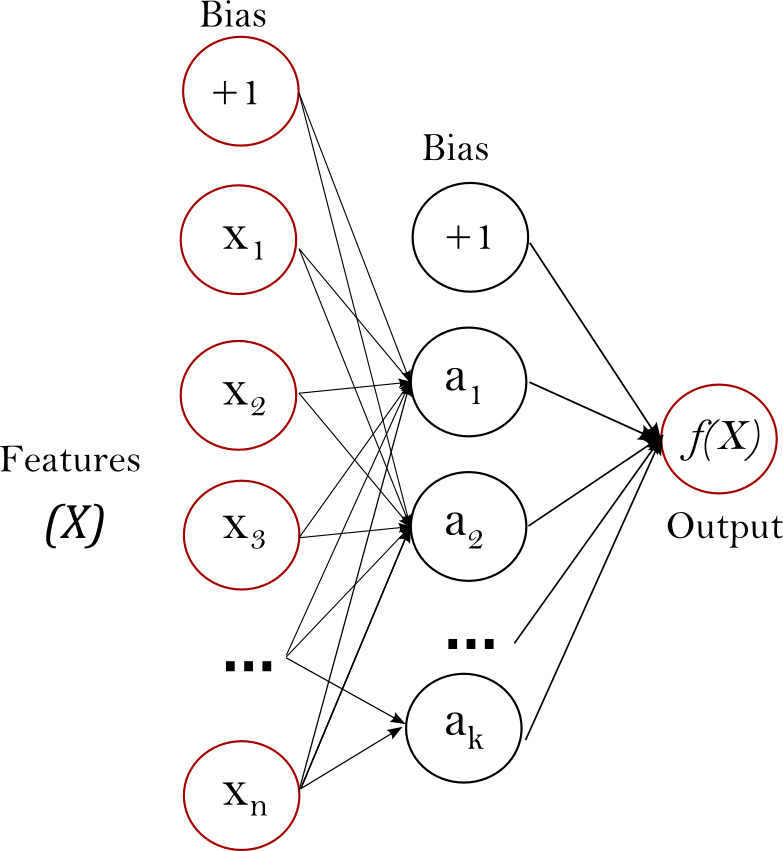

In [12]:
class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=None):
        super().__init__()
        if hidden_size is None:
            hidden_size = int(pow(in_features + out_features, 0.5))
            
        self.sequential = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_features)
        )
        
    def forward(self, x):
        return self.sequential(x)

In [13]:
# Initialize DataLoaders - objects, which sample instances from DataObject-s
train_dl = DataLoader(
    MyDataset(X_train, y_train),
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_dl = DataLoader(
    MyDataset(X_val, y_val),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False    
)

test_dl = DataLoader(
    MyDataset(X_test, y_test),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
)

dls = {'train': train_dl, 'val': val_dl, 'test': test_dl}

In [14]:
torch.manual_seed(SEED)

model = Model(in_features = X_train.shape[1], out_features=1)
model.to(DEVICE)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [16]:
# Training loop
metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Val RMSE": [],
}

# Train loop
for epoch in tqdm(range(300)):
    metrics_dict["Epoch"].append(epoch)
    for stage in ['train', 'val']:
        with torch.set_grad_enabled(stage == 'train'): # Whether to start building a graph for a backward pass
            if stage == 'train':
                model.train() # Enable some "special" layers (will speak about later)
            else:
                model.eval() # Disable some "special" layers (will speak about later)

            loss_at_stage = 0 
            for batch in dls[stage]:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

                y_pred = model(x_batch).view(-1) # forward pass: model(x_batch) -> calls forward()
                loss = loss_fn(y_pred, y_batch) # ¡Important! y_pred is always the first arg
                if stage == "train":
                    loss.backward() # Calculate the gradients of all the parameters wrt loss
                    optimizer.step() # Update the parameters
                    # scheduler.step()
                    optimizer.zero_grad() # Zero the saved gradient
                with torch.no_grad():
                    loss_at_stage += (torch.square((y_pred - y_batch)).sum()).item() #  * ss2.scale_[0]
            rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
            metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)
            
    clear_output(wait=True)
    display(pd.DataFrame(metrics_dict))

,Epoch,Train RMSE,Val RMSE
0,0,186936.509552,173464.763792
1,1,147920.484951,113041.584059
2,2,99378.214023,64092.803826
3,3,88790.739092,59689.560518
4,4,79973.232284,61614.987277
...,...,...,...
295,295,45521.376047,39638.652844
296,296,45183.625503,40368.711641
297,297,46185.478897,40463.091851
298,298,45261.220533,39308.853490


In [20]:
def rmse(preds, y_true):
    return ((preds - y_true) ** 2).mean() ** (1/2)

def eval_loop(model, X_val, X_test, y_val, y_test, model_is_nn=True, model_name="NN"):
    print(f"Model {model_name}")
    for name, x_eval, y_eval in zip(['val', 'test'], [X_val, X_test], [y_val, y_test]):
        if model_is_nn:
            with torch.no_grad():
                preds = model(torch.Tensor(x_eval)).view(-1)
        else:
            model.fit(X_train, y_train)
            preds = model.predict(x_eval)
        # Don't forget to rescale the results back to measure loss in original space
        preds_rescheduled = preds# * ss2.scale_ + ss2.mean_
        y_eval_rescheduled = y_eval# * ss2.scale_ + ss2.mean_
        rmse_val = rmse(preds_rescheduled, y_eval_rescheduled)
        print(f'{name}: RMSE = {rmse_val:.2f}')

In [21]:
eval_loop(model, X_val, X_test, y_val, y_test, model_is_nn=True, model_name="NN")

Model NN
val: RMSE = 40123.35
test: RMSE = 44616.81


In [22]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
eval_loop(LinearRegression(), X_val, X_test, y_val, y_test, model_is_nn=False, model_name="LinReg")
eval_loop(RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]),
          X_val, X_test, y_val, y_test, model_is_nn=False, model_name="Ridge")
eval_loop(LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]),
          X_val, X_test, y_val, y_test, model_is_nn=False, model_name="Lasso")

Model LinReg
val: RMSE = 32117.35
test: RMSE = 38127.42
Model Ridge
val: RMSE = 32064.99
test: RMSE = 38059.23
Model Lasso
val: RMSE = 32070.77


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431767781376.0, tolerance: 435219520.0
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 448908656640.0, tolerance: 435219520.0
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450517336064.0, tolerance: 435219520.0
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the numb

test: RMSE = 38145.22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491795677184.0, tolerance: 459529088.0
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492234735616.0, tolerance: 459529088.0
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16754609152.0, tolerance: 434775392.0
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the numbe